# Classification of images in CIFAR-10 database by Random Forest Classifier

In [23]:
import numpy as np
import pandas as pd
from collections import OrderedDict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from time import time
import warnings

warnings.filterwarnings('ignore')#mute the warning messages

## Data preprocessing

The dataset labeled as "train" has 50000 images saved as png files and a csv file with labels to identify each of these files are also available. We will use this dataset and split it into a training set and testing set for this project.

The major task in the data preprocessing is to extract RGB from the png files and format the data as formats that are readily readable by the classifer.

In [5]:
#total number of images
img_num = 50000
#read the train set
print ("Loading the dataset...")
X=[]
for i in range(1, img_num+1):
    filename ='train/'+str(i)+'.png'
    data = mpimg.imread(filename)
    X.append(data)
print ("Raw data loaded!")

#load the labels 
label_o = pd.read_csv("trainLabels.csv")
class_le = LabelEncoder()
label_ = class_le.fit_transform(label_o['label'])
y = np.array(label_)
print ("Labels loaded!")

#split the training and testing datasets (80% training, 20% testing)
train_X=np.array(X[:40000]).reshape(-1,3072)
test_X=np.array(X[40000:]).reshape(-1,3072)
train_y=np.array(y[:40000])
test_y=np.array(y[40000:])

Loading the dataset...
Raw data loaded!
Labels loaded!


# Model optimization

We first try to understand how some the of the key parameters affect the performance of a random forest classifier with the training set in this project, and based on the result a optimal set of parameter are selected.

Within the evaluated range, it seems that after n_estimators is larger than 400, the reduction of error rate becomes relatively incremental. Evaluating the error rate for even larger n_estimator quickly becomes expensive in terms of time, and may be less "cost-effective". For this analysis, we picked n_estimator = 500. We would like to keep the evaluation of even larger n_estimators for future work.

RandomForestClassifier, max_feature='sqrt'  fit for  10 estimators 
RandomForestClassifier, max_feature='sqrt'  fit for  60 estimators 
RandomForestClassifier, max_feature='sqrt'  fit for  110 estimators 
RandomForestClassifier, max_feature='sqrt'  fit for  160 estimators 
RandomForestClassifier, max_feature='sqrt'  fit for  210 estimators 
RandomForestClassifier, max_feature='sqrt'  fit for  260 estimators 
RandomForestClassifier, max_feature='sqrt'  fit for  310 estimators 
RandomForestClassifier, max_feature='sqrt'  fit for  360 estimators 
RandomForestClassifier, max_feature='sqrt'  fit for  410 estimators 
RandomForestClassifier, max_feature='sqrt'  fit for  460 estimators 
RandomForestClassifier, max_feature='sqrt'  fit for  510 estimators 
RandomForestClassifier, max_feature='log2  fit for  10 estimators 
RandomForestClassifier, max_feature='log2  fit for  60 estimators 
RandomForestClassifier, max_feature='log2  fit for  110 estimators 
RandomForestClassifier, max_feature='log2

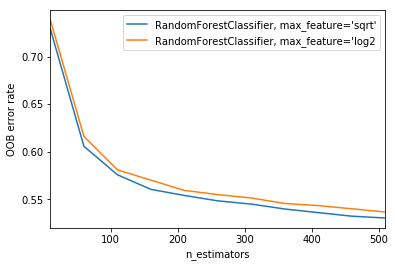

In [29]:
#define a function to explore the optimal n_estimators setting
def mod_optimization (min_estimator, max_estimator, step, train_X, train_y):

    RANDOM_STATE = 123

    #define a list of classifiers with different splitting options (max_features)
    ensemble_classifiers = [("RandomForestClassifier, max_feature='sqrt'", 
                             RandomForestClassifier(warm_start=True, oob_score=True, max_features='sqrt', 
                                                    random_state=RANDOM_STATE, n_jobs=-1)),
                           ("RandomForestClassifier, max_feature='log2", 
                           RandomForestClassifier(warm_start=True, oob_score=True, max_features='log2',
                                                 random_state=RANDOM_STATE, n_jobs=-1))]

    error_rate = OrderedDict((label, []) for label, _ in ensemble_classifiers)

    #model evaluation
    for label, classifier in ensemble_classifiers:
        for i in range(min_estimator, max_estimator + 1, step):
            classifier.set_params(n_estimators = i )
            classifier.fit(train_X, train_y)
            print(label," fit for ", i, "estimators ")

            oob_error = 1 - classifier.oob_score_
            error_rate[label].append((i, oob_error))

    #plot the error vs the number of estimators
    for label, error in error_rate.items():
        x, y = zip(*error)
        plt.plot(x, y, label=label)

    plt.xlim(min_estimator, max_estimator)
    plt.xlabel("n_estimators")
    plt.ylabel("OOB error rate")
    plt.legend(loc="upper right")
    plt.show()
    

mod_optimization(10, 510, 50, train_X, train_y)

## Fit the model

Based on the model optimization above, n_estimators = 500 was selected for the random forest classifier in thr formal analysis.

In [30]:
#train the random forest classifier
start = time()
rf_cifar = RandomForestClassifier(n_jobs=-1, n_estimators=500)
#The first 35000 labels correpond to the images used as training set
rf_cifar.fit(train_X, train_y)
end = time()
print ("Model trained!")
print("Training accuracy:", rf_cifar.score(train_X, train_y))
print("Elapsed time: ", (end-start)/60.)

Model trained!
Training accuracy: 1.0
Elapsed time:  5.4784034530321755


## Evaluate the model

In [31]:
#evaluate the performance of the classifier

pred_y = rf_cifar.predict(test_X)
result = precision_recall_fscore_support(test_y, pred_y)
classes = [class_le.inverse_transform(i) for i in rf_cifar.classes_]
print ("Precision:")
for i in range(len(classes)):
    print(classes[i],':', result[0][i])
print ("\nRecall:")
for i in range(len(classes)):
    print(classes[i],':', result[1][i])

print ("\nOverall accuracy: ", accuracy_score(test_y, pred_y))

Precision:
airplane : 0.567398119122
automobile : 0.521781219748
bird : 0.388607594937
cat : 0.404109589041
deer : 0.400801603206
dog : 0.425349087003
frog : 0.450826121164
horse : 0.520134228188
ship : 0.585454545455
truck : 0.47762345679

Recall:
airplane : 0.53550295858
automobile : 0.531558185404
bird : 0.322478991597
cat : 0.290354330709
deer : 0.401203610832
dog : 0.386341463415
frog : 0.584693877551
horse : 0.475946775844
ship : 0.642073778664
truck : 0.605675146771

Overall accuracy:  0.4781


# Classification of the handwritten digits in the MNIST database by Random Forest Classifier

## Data preprocessing

Images have been preprocessed and readily available in the tensorflow package. For this analysis, we just import data as numpy arrays.

In [27]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=False)

Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


The data extracted from the tensorflow package are typically in tuples. Each element, which is an array, in the tuples represents an image. Because the images are gray, the dimension of each image is 28x28. There 55000 images in the training set and 10000 images in the testing set.

# Optimize the model

Similar optimization practice was conducted by using the mod_optimization function defined in the previous steps. The primary purpose was to identify the optimal n_estimators.

RandomForestClassifier, max_feature='sqrt'  fit for  10 estimators 
RandomForestClassifier, max_feature='sqrt'  fit for  60 estimators 
RandomForestClassifier, max_feature='sqrt'  fit for  110 estimators 
RandomForestClassifier, max_feature='sqrt'  fit for  160 estimators 
RandomForestClassifier, max_feature='sqrt'  fit for  210 estimators 
RandomForestClassifier, max_feature='sqrt'  fit for  260 estimators 
RandomForestClassifier, max_feature='sqrt'  fit for  310 estimators 
RandomForestClassifier, max_feature='sqrt'  fit for  360 estimators 
RandomForestClassifier, max_feature='sqrt'  fit for  410 estimators 
RandomForestClassifier, max_feature='sqrt'  fit for  460 estimators 
RandomForestClassifier, max_feature='sqrt'  fit for  510 estimators 
RandomForestClassifier, max_feature='log2  fit for  10 estimators 
RandomForestClassifier, max_feature='log2  fit for  60 estimators 
RandomForestClassifier, max_feature='log2  fit for  110 estimators 
RandomForestClassifier, max_feature='log2

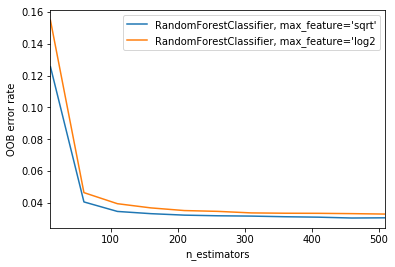

In [33]:
train_X = np.array([img.flatten(1) for img in mnist.train.images])
train_y = mnist.train.labels

mod_optimization (10, 510, 50, train_X, train_y)

# Fit the model

After n_estimator is larger than 200 or 300, the classification error becomes relatively stable. Thus, we selected 300 as the n_estimator after balancing the time cost and increased accuracy.

In [38]:
start = time()
rf_mnist = RandomForestClassifier(n_jobs=-1, n_estimators=300)
rf_mnist.fit(train_X, train_y)
end = time()

et = (end - start)/60.
print("Model trained!")
print ("Mean accuracy:", rf_mnist.score(train_X,train_y))
print ("Elapse time: ", et, "minutes")

Model trained!
Mean accuracy: 1.0
Elapse time:  0.7186755140622457 minutes


## Evaluate the model

In [39]:
test_X = np.array([img.flatten(1) for img in mnist.test.images])
test_y = mnist.test.labels

test_y_pred = rf_mnist.predict(test_X)


result = precision_recall_fscore_support(test_y, test_y_pred)
classes = [i for i in range(10)]
print ("Precision:")
for i in range(len(classes)):
    print(classes[i],':', result[0][i])
print ("\nRecall:")
for i in range(len(classes)):
    print(classes[i],':', result[1][i])
    
print("Overal scores:", accuracy_score(test_y, test_y_pred))

Precision:
0 : 0.972945891784
1 : 0.991166077739
2 : 0.963391136802
3 : 0.962413452028
4 : 0.971544715447
5 : 0.975113122172
6 : 0.974039460021
7 : 0.9736328125
8 : 0.963768115942
9 : 0.961

Recall:
0 : 0.990816326531
1 : 0.988546255507
2 : 0.968992248062
3 : 0.963366336634
4 : 0.973523421589
5 : 0.966367713004
6 : 0.979123173278
7 : 0.969844357977
8 : 0.955852156057
9 : 0.95242814668
Overal scores: 0.9711
